# Python Configuration

In [9]:
# python version:
from platform import python_version
print(f"python version = {python_version()}")

# We used the following version:
# python version = 3.8.6

python version = 3.8.6


In [10]:
# python standard library packages:
import importlib
import pickle

# import more packages:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

# import own package:
import functions as my

# the following package is only needed to view data interactively,
# otherwise you can comment the import out:
import qgrid  # https://github.com/quantopian/qgrid

In [11]:
# package versions:
print(f"numpy      version = {np.__version__}")
print(f"pandas     version = {pd.__version__}")
print(f"matplotlib version = {matplotlib.__version__}")

# the following package is only needed to view data interactively,
# otherwise you can comment this out:
print(f"qgrid      version = {qgrid.__version__}")

# We used the following versions:
# numpy      version = 1.19.2
# pandas     version = 1.1.3
# matplotlib version = 3.3.2
# qgrid      version = 1.3.1

numpy      version = 1.19.2
pandas     version = 1.1.3
matplotlib version = 3.3.2
qgrid      version = 1.3.1


# Synced and Match Data

- Synced: RG, DA, PV to common time frame of the year 2016
- Match: 
    + EV: May 2013 - Nov 2015: match to 2016
    + HH: Jul 2009 - Dec 2010: match to 2016
    
time changes in 2016: [link](https://www.schulferien.org/deutschland/zeit/zeitumstellung/2016/)

- 27. March:   02:00 -> 03:00
- 30. October: 02:00 <- 03:00

In [12]:
# first day in 2016 was a Friday (coded as 4 in pandas):
pd.Timestamp("2016-01-01").weekday()

4

## Synced Data

### Aggregate

In [13]:
my_pv_df = pd.read_pickle('../data/pv/processed/pv_df.pickle')
# my_pv_df

In [14]:
my_rg_df = pd.read_pickle('../data/rg/processed/rg_df.pickle')
# my_rg_df

In [15]:
my_da_df = pd.read_pickle('../data/da/processed/da_df.pickle')
# my_da_df

In [16]:
# aggregate:
my_df_sync = my_pv_df
my_df_sync = my_df_sync.join(my_rg_df, how='outer')
my_df_sync = my_df_sync.join(my_da_df, how='outer')

In [17]:
my_df_sync.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 35136 entries, 2016-01-01 00:00:00 to 2016-12-31 23:45:00
Freq: 15T
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   PV_kW       35136 non-null  float64
 1   PV_kW_pred  35136 non-null  float64
 2   RG_MW       35136 non-null  float64
 3   DA_EUR/MWh  35136 non-null  float64
dtypes: float64(4)
memory usage: 2.6 MB


In [18]:
my_df_sync.head(3)
# my_df_sync.tail(3)

,PV_kW,PV_kW_pred,RG_MW,DA_EUR/MWh
2016-01-01 00:00:00,0.0,0.0,8878.35,23.8600
2016-01-01 00:15:00,0.0,0.0,8687.59,23.4925
2016-01-01 00:30:00,0.0,0.0,8553.69,23.1250


In [19]:
# view all data:
# qgrid.show_grid(my_df_sync)

### Checks

In [20]:
importlib.reload(my);

my.checks(my_df_sync, my_year='2016')

- check for rows with a NaN value: OK
- check for duplicate timestamps : OK
- check for set of timestamps    : OK


### Export

In [21]:
# export to pickle:
my_df_sync.to_pickle(
    "../data/aggregate/processed/my_df_sync.pickle")
if 0: # export to csv:
    my_df_sync.to_csv(
        "../data/aggregate/processed/my_df_sync.csv")

In [22]:
# import again:
my_df_sync = pd.read_pickle("../data/aggregate/processed/my_df_sync.pickle")

## Match EV Data

Data encompasses 

- trips    between 2013-05-07 - 2015-11-29
- charging between 2013-12-20 - 2015-11-29

### Example

#### Select

In [23]:
# get all processed participant IDs:
with open ('../data/ev/processed/participant_IDs.pickle', 'rb') as fp:
    my_participants = pickle.load(fp)

In [24]:
my_participant = my_participants[0]
# my_participant = "BL04"
print(f"selected participant = {my_participant}")

my_df_ev = pd.read_pickle(f"../data/ev/processed/ev_df_{my_participant}.pickle")
my_df_ev.head(3)

selected participant = BL01


,driving_bool,power_kW,charging_bool,loadable_bool
2014-07-04 17:00:00,False,0.0,False,True
2014-07-04 17:15:00,False,0.0,False,True
2014-07-04 17:30:00,False,0.0,False,True


#### Checks

In [25]:
importlib.reload(my);

my.checks(my_df_ev, my_year='')

- check for rows with a NaN value: OK
- check for duplicate timestamps : OK
INFO: no check for set of timestamps performed.


#### Match

strategy:

1. check if data comprises more than 366 + x days
2. match 366 days of 2016 such that weekdays correspond

In [26]:
print(f"EV data start: {my_df_ev.index[ 0]}.")
print(f"EV data end:   {my_df_ev.index[-1]}.")

EV data start: 2014-07-04 17:00:00.
EV data end:   2015-11-28 19:30:00.


In [27]:
# check if data encompasses enough days for matching:
my_time_delta = my_df_ev.index[-1] - my_df_ev.index[0]
if my_time_delta/pd.Timedelta('1 day') >= 366 + 10:
    print('yes')
else: 
    print('no')

yes


In [28]:
# check if Saturday 3 January 2015 00:00:00 is in data:
if pd.Timestamp('2015-01-03') <= my_df_ev.index[-1]:
    my_start_day_str = '2015-01-02' # Friday is entirely in data
    my_start_day = pd.Timestamp('2015-01-02').date()
# check if Saturday 4 January 2014 00:00:00 is in data:
elif pd.Timestamp('2014-01-04') < my_df_ev.index[-1]: 
    my_start_day_str = '2014-01-03' # Friday is entirely in data
    my_start_day = pd.Timestamp('2014-01-03').date()
else:
    my_start_day_str = None
    print("No appropriate start day found.!")
    
if not my_start_day_str is None:
    my_future_day = np.unique(my_df_ev.index.date)[-2] #.strftime(format="%Y-%m-%d")
    my_future_day_str = my_future_day.strftime(format='%Y-%m-%d')
    my_days_part_1 = (my_future_day - my_start_day)/pd.Timedelta('1 day') + 1
    print(f"{my_future_day.weekday() = }")

    my_past_day = my_df_ev.index[-2] - pd.Timedelta(365, unit='days')
    my_past_day = my_past_day.date()

    my_past_day_wanted_weekday = my_future_day.weekday() + 1
    print(f"{my_past_day_wanted_weekday = }")

    if my_past_day.weekday() != my_past_day_wanted_weekday:
        my_days_diff = my_past_day.weekday() - my_past_day_wanted_weekday
        if my_days_diff > 0:
            my_past_day = my_past_day - pd.Timedelta(my_days_diff, unit='days')
        else:
            my_past_day = my_past_day - pd.Timedelta(my_days_diff + 7, unit='days')
    if my_past_day.weekday() != my_past_day_wanted_weekday:
        print(f"Weekday correction did not work!")
    else:
        my_past_day_str = my_past_day.strftime(format='%Y-%m-%d')
        print(f"{my_past_day.weekday() = }")
    my_days_part_2 = 366 - my_days_part_1
    my_end_day = my_past_day + pd.Timedelta(my_days_part_2 - 1, unit='days')
    my_end_day_str = my_end_day.strftime(format='%Y-%m-%d')
    print("")
    print(f"my_start_day  = {my_start_day_str}")
    print(f"my_future_day = {my_future_day_str}")
    print(f"my_past_day   = {my_past_day_str}")
    print(f"my_end_day    = {my_end_day_str}")

my_future_day.weekday() = 4
my_past_day_wanted_weekday = 5
my_past_day.weekday() = 5

my_start_day  = 2015-01-02
my_future_day = 2015-11-27
my_past_day   = 2014-11-22
my_end_day    = 2014-12-27


In [29]:
# create my_df_ev_2016
my_end = pd.Timestamp("2016-01-01 23:45:00") + pd.Timedelta(my_days_part_1 - 1, unit='days')
my_index = pd.date_range(start='2016-01-01', end=my_end, freq='15min')
my_df_ev_2016 = pd.DataFrame(my_df_ev.loc[my_start_day_str:my_future_day_str, ].values,
                             columns=my_df_ev.columns,
                             index=my_index)
# my_df_ev_2016

In [30]:
my_start = pd.Timestamp("2016-01-01 00:00:00") + pd.Timedelta(my_days_part_1, unit='days')
my_index = pd.date_range(start=my_start, end="2016-12-31 23:45:00", freq='15min')
my_df_ev_2016_addon = pd.DataFrame(my_df_ev.loc[my_past_day_str:my_end_day_str, ].values,
                                   columns=my_df_ev.columns,
                                   index=my_index)
# my_df_ev_2016_addon

In [31]:
my_df_ev_2016 = my_df_ev_2016.append(my_df_ev_2016_addon)

In [32]:
importlib.reload(my);

my.checks(my_df_ev_2016, my_year='2016')

- check for rows with a NaN value: OK
- check for duplicate timestamps : OK
- check for set of timestamps    : OK


In [33]:
# view all data:
# qgrid.show_grid(my_df_ev_2016)

### Batch Matching

In [34]:
# get all processed participant IDs:
with open ('../data/ev/processed/participant_IDs.pickle', 'rb') as fp:
    my_participants = pickle.load(fp)

In [35]:
importlib.reload(my);

for my_participant in my_participants:
    print(f"working on participant {my_participant} ... ")
    my_df_ev_2016 = my.match_ev(my_participant, verbose=False)
    # export to pickle:
    my_df_ev_2016.to_pickle(
        f"../data/aggregate/processed/ev_df_{my_participant}.pickle")
    if 0: # export to csv:
        my_df_ev_2016.to_csv(
            f"../data/aggregate/processed/ev_df_{my_participant}.csv")
    print("  ... finished.")
    
# write selected participant IDs to a pickle file:
print(f"writing selected participant IDs to a pickle file ... ", end="")
with open('../data/aggregate/processed/ev_participant_IDs.pickle', 'wb') as fp:
    pickle.dump(my_participants, fp)
print("finished.")
    
print("Finished all.")

working on participant BL01 ... 
  ... finished.
working on participant BL02 ... 
  ... finished.
working on participant BL03 ... 
  ... finished.
working on participant BL04 ... 
  ... finished.
working on participant BL05 ... 
  ... finished.
working on participant BL06 ... 
  ... finished.
working on participant BL08 ... 
  ... finished.
working on participant CC01 ... 
  ... finished.
working on participant CC02 ... 
  ... finished.
working on participant CC04 ... 
  ... finished.
writing selected participant IDs to a pickle file ... finished.
Finished all.


## Match HH Data

Data encompasses July 2009 to Dec 2010.

Jan 1 2010 was a Friday!

### Example

#### Select

**SELECT raw file:**

In [36]:
my_file_number = 1   # 1 - 6 corresponding to File1.txt - File6.txt

In [37]:
# get all processed residential IDs of a raw data file:
with open (f'../data/hh/processed/residential_IDs_file{my_file_number}.pickle', 'rb') as fp:
    my_file_residential_IDs = pickle.load(fp)

**SELECT residential:**

In [38]:
my_residential_ID = my_file_residential_IDs[0]
# my_residential_ID = "1002"
print(f"selected residential = {my_residential_ID}")

selected residential = 1002


In [39]:
# load residential data:
my_df_hh = pd.read_pickle(f"../data/hh/processed/hh_df_{my_residential_ID}.pickle")
my_df_hh.head(3)

,HH_kW
,
2009-07-14 00:00:00,0.704976
2009-07-14 00:15:00,0.414806
2009-07-14 00:30:00,0.124637


In [40]:
my_df_hh.tail(3)

,HH_kW
,
2010-12-31 22:30:00,0.286275
2010-12-31 22:45:00,0.394358
2010-12-31 23:00:00,0.502441


#### Checks

In [41]:
importlib.reload(my);

my.checks(my_df_hh, my_year='')

- check for rows with a NaN value: OK
- check for duplicate timestamps : OK
INFO: no check for set of timestamps performed.


#### Match

strategy:

1. check if data comprises more than 366 + x days
2. match 366 days of 2016 such that weekdays correspond

In [42]:
my_start_day_str = '2010-01-01' # Friday
my_start_day = pd.Timestamp('2010-01-01').date()

In [43]:
my_future_day = np.unique(my_df_hh.index.date)[-2] #.strftime(format="%Y-%m-%d")
my_future_day_str = my_future_day.strftime(format='%Y-%m-%d')
my_days_part_1 = (my_future_day - my_start_day)/pd.Timedelta('1 day') + 1
print(f"{my_future_day.weekday() = }")

my_past_day = my_df_hh.index[-2] - pd.Timedelta(365, unit='days')
my_past_day = my_past_day.date()

my_past_day_wanted_weekday = my_future_day.weekday() + 1
print(f"{my_past_day_wanted_weekday = }")

if my_past_day.weekday() != my_past_day_wanted_weekday:
    my_days_diff = my_past_day.weekday() - my_past_day_wanted_weekday
    if my_days_diff > 0:
        my_past_day = my_past_day - pd.Timedelta(my_days_diff, unit='days')
    else:
        my_past_day = my_past_day - pd.Timedelta(my_days_diff + 7, unit='days')
if my_past_day.weekday() != my_past_day_wanted_weekday:
    print(f"Weekday correction did not work!")
else:
    my_past_day_str = my_past_day.strftime(format='%Y-%m-%d')
    print(f"{my_past_day.weekday() = }")
my_days_part_2 = 366 - my_days_part_1
my_end_day = my_past_day + pd.Timedelta(my_days_part_2 - 1, unit='days')
my_end_day_str = my_end_day.strftime(format='%Y-%m-%d')
print("")
print(f"my_start_day  = {my_start_day_str}")
print(f"my_future_day = {my_future_day_str}")
print(f"my_past_day   = {my_past_day_str}")
print(f"my_end_day    = {my_end_day_str}")

my_future_day.weekday() = 3
my_past_day_wanted_weekday = 4
my_past_day.weekday() = 4

my_start_day  = 2010-01-01
my_future_day = 2010-12-30
my_past_day   = 2009-12-25
my_end_day    = 2009-12-26


In [44]:
# create my_hh_2016:
my_end = pd.Timestamp("2016-01-01 23:45:00") + pd.Timedelta(my_days_part_1 - 1, unit='days')
my_index = pd.date_range(start='2016-01-01', end=my_end, freq='15min')
my_df_hh_2016 = pd.DataFrame(my_df_hh.loc[my_start_day_str:my_future_day_str, ].values,
                             columns=my_df_hh.columns,
                             index=my_index)
# my_df_hh_2016

In [45]:
my_start = pd.Timestamp("2016-01-01 00:00:00") + pd.Timedelta(my_days_part_1, unit='days')
my_index = pd.date_range(start=my_start, end="2016-12-31 23:45:00", freq='15min')
my_df_hh_2016_addon = pd.DataFrame(my_df_hh.loc[my_past_day_str:my_end_day_str, ].values,
                                   columns=my_df_hh.columns,
                                   index=my_index)
# my_df_hh_2016_addon

In [46]:
my_df_hh_2016 = my_df_hh_2016.append(my_df_hh_2016_addon)

In [47]:
importlib.reload(my);

my.checks(my_df_hh_2016, my_year='2016')

- check for rows with a NaN value: OK
- check for duplicate timestamps : OK
- check for set of timestamps    : OK


In [48]:
# view all data:
# qgrid.show_grid(my_df_hh_2016)

### Batch Matching

In [49]:
# get all processed residential IDs of a raw data file:

my_file_number = 1   # 1 - 6

with open (f'../data/hh/processed/residential_IDs_file{my_file_number}.pickle', 'rb') as fp:
    my_file_residential_IDs = pickle.load(fp)

In [50]:
importlib.reload(my);

for my_residential_ID in my_file_residential_IDs:
    print(f"working on residential {my_residential_ID} ... ")
    my_df_hh_2016 = my.match_hh(my_residential_ID, verbose=False)
    # export to pickle:
    my_df_hh_2016.to_pickle(
        f"../data/aggregate/processed/hh_df_{my_residential_ID}.pickle")
    if 0: # export to csv:
        my_df_hh_2016.to_csv(
            f"../data/aggregate/processed/hh_df_{my_residential_ID}.csv")
    print("  ... finished.")

# write selected residential IDs to a pickle file:
print(f"writing selected residential IDs to a pickle file ... ", end="")
with open(f"../data/aggregate/processed/hh_residential_IDs_file{my_file_number}.pickle", 'wb') as fp:
    pickle.dump(my_file_residential_IDs, fp)
print("finished.")
    
print("Finished all.")

working on residential 1002 ... 
  ... finished.
working on residential 1003 ... 
  ... finished.
working on residential 1004 ... 
  ... finished.
working on residential 1005 ... 
  ... finished.
working on residential 1006 ... 
  ... finished.
working on residential 1008 ... 
  ... finished.
working on residential 1009 ... 
  ... finished.
working on residential 1013 ... 
  ... finished.
working on residential 1014 ... 
  ... finished.
working on residential 1015 ... 
  ... finished.
working on residential 1016 ... 
  ... finished.
working on residential 1018 ... 
  ... finished.
working on residential 1020 ... 
  ... finished.
working on residential 1022 ... 
  ... finished.
working on residential 1024 ... 
  ... finished.
working on residential 1025 ... 
  ... finished.
working on residential 1027 ... 
  ... finished.
working on residential 1030 ... 
  ... finished.
working on residential 1033 ... 
  ... finished.
working on residential 1034 ... 
  ... finished.
writing selected res

# View Data

In [51]:
my_day = "2016-10-10"

my_day_ts = pd.Timestamp(my_day)
# Monday == 0 ... Sunday == 6
my_weekdays = {0: 'Monday',
               1: 'Tuesday',
               2: 'Wednesday',
               3: 'Thursday',
               4: 'Friday',
               5: 'Saturday',
               6: 'Sunday'}
print(f"The selected day was a {my_weekdays[my_day_ts.weekday()]}.") 

The selected day was a Monday.


## Synced Data

In [52]:
my_df_sync = pd.read_pickle("../data/aggregate/processed/my_df_sync.pickle")

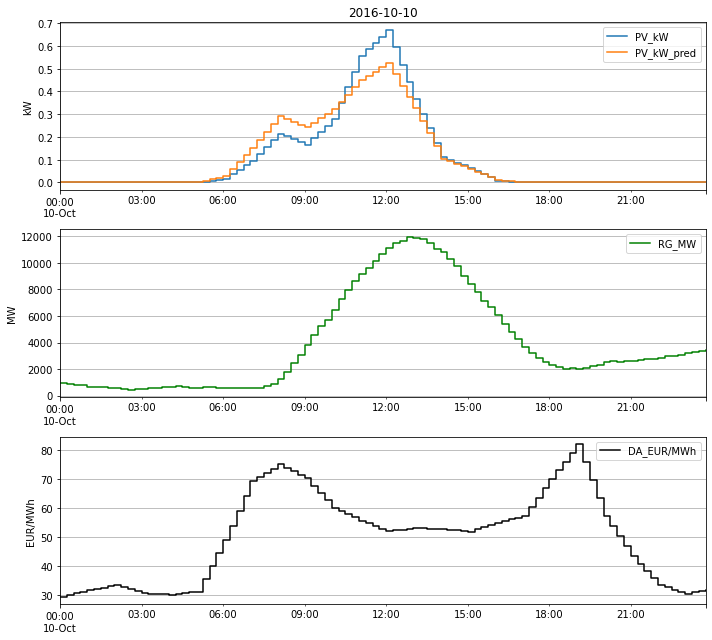

In [53]:
fig, axes = plt.subplots(nrows=3, ncols=1);

my_df_sync.loc[my_day,['PV_kW','PV_kW_pred']].plot(ax=axes[0], title=my_day,
    figsize=(10,9), grid=True, ylabel='kW', drawstyle="steps-post");
my_df_sync.loc[my_day,['RG_MW']].plot(ax=axes[1], 
    grid=True, ylabel='MW', color='green',drawstyle="steps-post");
my_df_sync.loc[my_day,['DA_EUR/MWh']].plot(ax=axes[2], 
    grid=True, ylabel='EUR/MWh', color='black', drawstyle="steps-post");
plt.tight_layout();
# plt.savefig(f"../figures/PV_RG_DA_{my_day}.pdf")
plt.savefig(f"../figures/PV_RG_DA_{my_day}.png")

## Match Data

### EV

In [54]:
# get all processed participant IDs:
with open ('../data/aggregate/processed/ev_participant_IDs.pickle', 'rb') as fp:
    my_participants = pickle.load(fp)

In [55]:
my_participant = my_participants[1]
print(f"selected participant = {my_participant}")

my_df_ev_2016 = pd.read_pickle(f"../data/aggregate/processed/ev_df_{my_participant}.pickle")

selected participant = BL02


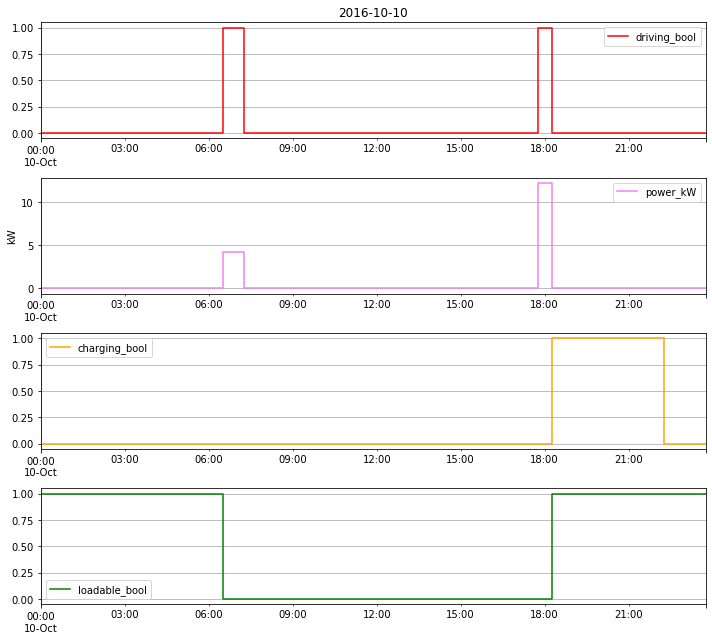

In [56]:
fig, axes = plt.subplots(nrows=4, ncols=1);
my_df_ev_2016.loc[my_day,['driving_bool']].astype(int).plot(ax=axes[0], grid=True, 
     figsize=(10,9), title=my_day, drawstyle="steps-post", color='red');
my_df_ev_2016.loc[my_day,['power_kW']].plot(ax=axes[1], grid=True, ylabel='kW',
     drawstyle="steps-post", color='violet');
my_df_ev_2016.loc[my_day,['charging_bool']].astype(int).plot(ax=axes[2], 
    grid=True, drawstyle="steps-post", color="orange");
my_df_ev_2016.loc[my_day,['loadable_bool']].astype(int).plot(ax=axes[3], 
    grid=True, drawstyle="steps-post", color='green');
plt.tight_layout()
# plt.savefig(f"../figures/EV_{my_day}.pdf")
plt.savefig(f"../figures/EV_{my_day}.png")

In [57]:
# qgrid.show_grid(my_df_ev_2016.loc[my_day,])

### HH

**SELECT raw file:**

In [58]:
my_file_number = 1   # 1 - 6 corresponding to File1.txt - File6.txt

In [59]:
# get all processed residential IDs of the selected raw data file:
with open (f'../data/hh/processed/residential_IDs_file{my_file_number}.pickle', 'rb') as fp:
    my_file_residential_IDs = pickle.load(fp)

**SELECT residential:**

In [60]:
my_residential_ID = my_file_residential_IDs[0]
print(f"selected residential = {my_residential_ID}")

my_df_hh_2016 = my.match_hh(my_residential_ID, verbose=False)

selected residential = 1002


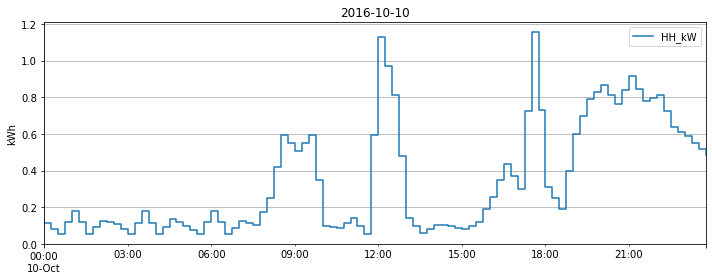

In [61]:
my_df_hh_2016.loc[my_day].plot(title=my_day, figsize=(10,4), 
    grid=True, ylabel='kWh', drawstyle="steps-post");
plt.tight_layout()
# plt.savefig(f"../figures/HH_{my_day}.pdf")
plt.savefig(f"../figures/HH_{my_day}.png")

In [62]:
# qgrid.show_grid(my_df_hh_2016.loc[my_day,])